In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Load the data
df = pd.read_csv('combined.csv')

# Strip any whitespace from column names
df.columns = df.columns.str.strip()

# Columns to remove, including IP addresses and ports which might not generalize well
columns_to_drop = ["flow ID", "source IP", "destination IP", "source port", "destination port", "date"]
df = df.drop(columns=columns_to_drop)

# Handle missing values
# For categorical data, replace missing values with a placeholder string
df.fillna({'protocol': 'Missing', 'firstPacketDIR': 'Missing', 'mostCommonREQ_FUNC_CODE': 'Missing', 
           'mostCommonRESP_FUNC_CODE': 'Missing'}, inplace=True)

# For numerical data, replace missing values with the median
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Encoding categorical variables
label_encoders = {}
categorical_columns = ['protocol', 'firstPacketDIR', 'mostCommonREQ_FUNC_CODE', 'mostCommonRESP_FUNC_CODE'] 
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Encoding target variable
le_label = LabelEncoder()
df['Label'] = le_label.fit_transform(df['Label'])

# Store the encoded labels separately and drop from dataframe
y = df['Label'].values
X = df.drop('Label', axis=1).values

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Handling imbalanced dataset with SMOTE
smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)
y_res = to_categorical(y_res)  # Convert labels to one-hot encoding for neural network
 

In [2]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)


In [3]:

# RNN model setup
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=True),  # Adjust the input shape based on the number of features
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Output layer neurons equal to number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/10
10694/10694 ━━━━━━━━━━━━━━━━━━━━ 503s 47ms/step - accuracy: 0.5795 - loss: 0.8034 - val_accuracy: 0.6867 - val_loss: 0.4991
Epoch 2/10
10694/10694 ━━━━━━━━━━━━━━━━━━━━ 496s 46ms/step - accuracy: 0.6845 - loss: 0.5034 - val_accuracy: 0.6874 - val_loss: 0.4996
Epoch 3/10
10694/10694 ━━━━━━━━━━━━━━━━━━━━ 494s 46ms/step - accuracy: 0.6920 - loss: 0.4816 - val_accuracy: 0.6965 - val_loss: 0.4670
Epoch 4/10
10694/10694 ━━━━━━━━━━━━━━━━━━━━ 497s 47ms/step - accuracy: 0.6926 - loss: 0.4741 - val_accuracy: 0.6996 - val_loss: 0.4634
Epoch 5/10
10694/10694 ━━━━━━━━━━━━━━━━━━━━ 495s 46ms/step - accuracy: 0.6960 - loss: 0.4679 - val_accuracy: 0.7008 - val_loss: 0.4613
Epoch 6/10
10694/10694 ━━━━━━━━━━━━━━━━━━━━ 502s 47ms/step - accuracy: 0.6979 - loss: 0.4655 - val_accuracy: 0.7044 - val_loss: 0.4550
Epoch 7/10
10694/10694 ━━━━━━━━━━━━━━━━━━━━ 503s 47ms/step - accuracy: 0.7013 - loss: 0.4596 - val_accuracy: 0.7024 - val_loss: 0.4539
Epoch 8/10
10694/10694 ━━━━━━━━━━━━━━━━━━━━ 499s 47ms/s

In [5]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot to labels
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

9166/9166 ━━━━━━━━━━━━━━━━━━━━ 106s 12ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     32590
           1       1.00      0.99      0.99     32681
           2       0.64      0.78      0.71     32310
           3       0.73      0.57      0.64     32706
           4       0.51      0.88      0.64     32617
           5       1.00      0.97      0.99     32661
           6       0.97      1.00      0.99     32516
           7       0.52      0.14      0.22     32701
           8       0.68      0.00      0.01     32514

    accuracy                           0.70    293296
   macro avg       0.73      0.70      0.65    293296
weighted avg       0.73      0.70      0.65    293296



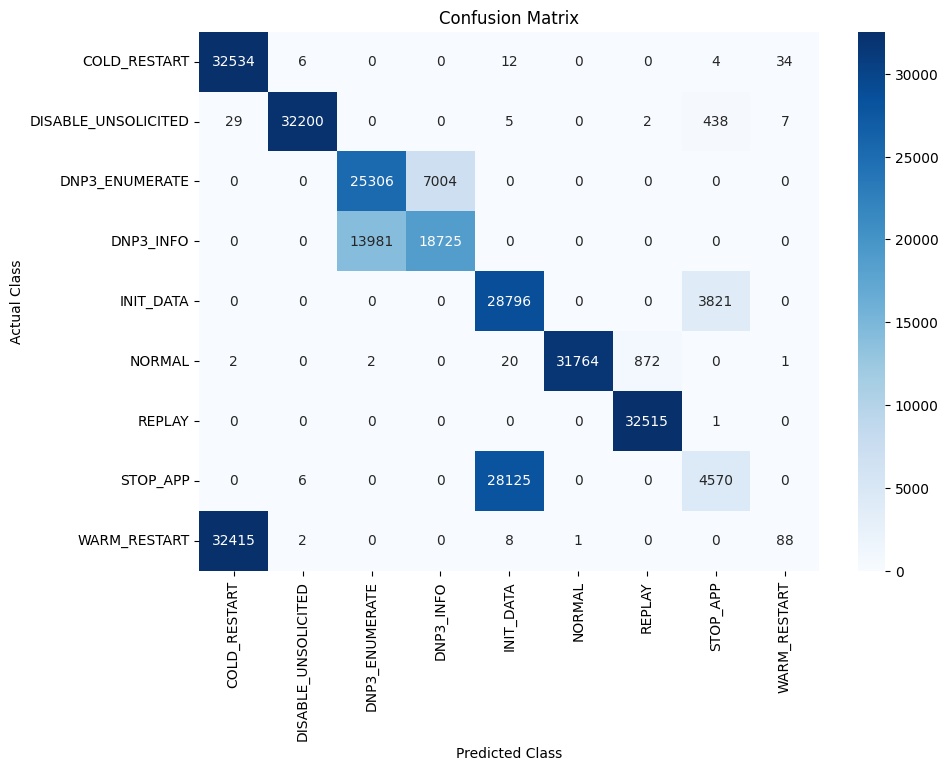

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred have been defined after model evaluation
# Print confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

# Get class names from LabelEncoder
class_names = le_label.classes_

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, class_names)


9166/9166 ━━━━━━━━━━━━━━━━━━━━ 99s 11ms/step


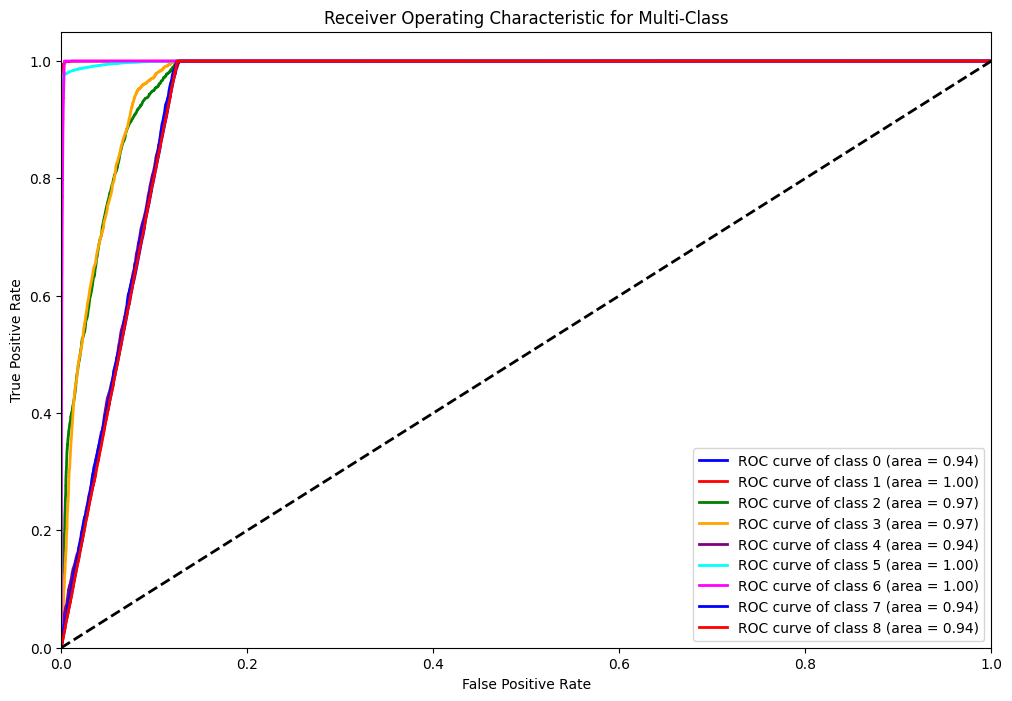

In [8]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Assuming y_test is available and is one-hot encoded and y_score has the predicted probabilities
y_score = model.predict(X_test)  # get the scores predicted by the model

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = y_test.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()
